In [2]:
%pylab inline
import pandas as pd
import fastparquet 
import os,sys

Populating the interactive namespace from numpy and matplotlib


In [3]:
sys.path.insert(0,"/mnt/lanlep2019/src/main")

In [4]:
!ln -s /mnt/lanlep2019 ~/

In [5]:
os.chdir("/mnt/lanlep2019/")

In [6]:
!pwd

/mnt/lanlep2019


# once

In [7]:
!pip install hyperopt


    100% |████████████████████████████████| 122kB 3.3MB/s ta 0:00:01
    100% |████████████████████████████████| 829kB 1.6MB/s  eta 0:00:01
    100% |████████████████████████████████| 1.7MB 796kB/s  eta 0:00:01
    100% |████████████████████████████████| 419kB 3.1MB/s  eta 0:00:01
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /home/hadoop/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /home/hadoop/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
Successfully built future networkx
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# data

In [7]:
import lightgbm as lgb

In [8]:
import data
import config

In [9]:
reload (data)

<module 'data' from '/mnt/lanlep2019/src/main/data.pyc'>

In [10]:
if 1:
    dataset=[]
    strategy = {'type':'rand', "fold":5}
    types=['kaggle','signal','kaggle2'] +['fwv','fwvext']+['fwvsoftmax','fwvdis','fwvdis2','fwvcos']+\
        ['fwvextsoftmax','fwvextdis','fwvextdis2','fwvextcos'] + ['fwvwholereg', 'fwvextwholereg']
    for offset in [0,37500, 75000,112500]:
        traintest = data.TrainTest('offset', offset=offset, types=types, transform=None, valid_strategy=strategy)
        dataset.append(traintest)

In [11]:
traintest.num_dataset()

5

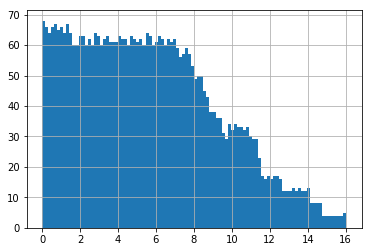

In [12]:
traintest.ydf.hist(bins=100);

In [13]:
np.abs(traintest.ydf-traintest.ydf.median()).mean()

3.0269177384241193

In [14]:
testdf=traintest.get_test_data()
testdf.shape

(2624, 450)

In [15]:
datadf=traintest.traindf
print datadf.shape
datadf.head()

(4173, 450)


mean         std     max     min  mean_change_abs  \
index                                                                  
quake_07_0405  4.622533    8.039286   251.0  -225.0         0.000033   
quake_07_0404  4.698080  112.349464  3449.0 -4482.0         0.000000   
quake_07_0159  4.141493    6.299701    94.0   -88.0         0.000007   
quake_07_0158  4.213913    5.103794    74.0  -100.0         0.000007   
quake_07_0401  4.225953    9.060598   192.0  -187.0         0.000053   

               mean_change_rate  abs_max  abs_min  std_first_50000  \
index                                                                
quake_07_0405      74755.976562    251.0      0.0         9.125431   
quake_07_0404      75871.375000   4482.0      0.0         5.712538   
quake_07_0159      75029.250000     94.0      0.0         6.280901   
quake_07_0158      75054.703125    100.0      0.0         5.603437   
quake_07_0401      75040.554688    192.0      0.0        10.612083   

               std_last_50000       ...         fwvextdis_pca10_2  \
index                               ...                             
quake_07_0405        7.902864       ...                  1.639194   
quake_07_0404       19.754288       ...                  4.808527   
quake_07_0159        6.027854       ...                  1.115260   
quake_07_0158        4.809473       ...                 -0.297501   
quake_07_0401        8.404730       ...                  2.205336   

               fwvextdis_pca10_3  fwvextdis_pca10_4  fwvextdis_pca10_5  \
index                                                                    
quake_07_0405           0.764217           0.218432          -0.007813   
quake_07_0404          -0.136472           0.502663           0.043488   
quake_07_0159           0.024505          -0.018302           0.079228   
quake_07_0158           0.168670           0.046252           0.023976   
quake_07_0401          -0.238119           0.012878           0.042690   

               fwvextdis_pca10_6  fwvextdis_pca10_7  fwvextdis_pca10_8  \
index                                                                    
quake_07_0405          -0.049034           0.021029           0.005735   
quake_07_0404           0.232533           0.001565          -0.059937   
quake_07_0159          -0.015695           0.031201           0.059025   
quake_07_0158           0.010945          -0.032556           0.000104   
quake_07_0401           0.015470          -0.028627           0.035620   

               fwvextdis_pca10_9  fwv_wholereg  fwvext_wholereg  
index                                                            
quake_07_0405           0.010838     77.421213        17.153645  
quake_07_0404          -0.009788    161.565558       119.035729  
quake_07_0159          -0.010276     -5.112977       -36.161473  
quake_07_0158          -0.003408     82.318870        33.999219  
quake_07_0401           0.040694      0.290691       -36.192186  

[5 rows x 450 columns]

In [16]:
import utils
n_thread= utils.get_num_thread()
n_thread

7

In [17]:
removed=[]

In [21]:
!mkdir -p input/sub/102

In [47]:
def make_sub(model, offset, fold):
    fname =os.path.join(config.INPUT_PATH, "sub", '102', "sub102_o{}_f{}.csv".format(offset, fold))
    print "write to " + fname    
    p = model.predict(testdf.values, num_iteration = model.best_iteration)
    p = pd.DataFrame(p, index=testdf.index).reset_index()
    p.columns=['seg_id','time_to_failure']
    p.to_csv(fname,index=None)

                        
    

In [48]:
def train_quake(traintest, offset, fold,params,n_thread):
    
    Xtr,ytr,Xte,yte=traintest.get_train_data(fold)
    Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
    print Xtr.shape,ytr.shape,Xte.shape,yte.shape
    if removed:
        Xtr[:,removed]=0
        Xte[:,removed]=0
    model = lgb.LGBMRegressor(n_estimators = 5000, n_jobs = n_thread, **params)
    model.fit(Xtr, ytr, sample_weight=None,
                    eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae', eval_sample_weight=None,
                    verbose=100, early_stopping_rounds=100)
    make_sub(model, offset,fold)
    return model.best_score['valid_1']['l1'], model.best_iteration

In [49]:
params = {'num_leaves': 54,
          'min_data_in_leaf': 79,
          'objective': 'mae',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }

In [50]:
best_mae=1e10

In [51]:
def lgbcv(learning_rate, num_leaves,reg_alpha,reg_lambda,max_depth,subsample,colsample_bytree, min_data_in_leaf,min_sum_hessian_in_leaf):
    d=locals()
    newparams=params.copy()
    newparams.update(d)    
    newparams['num_leaves']=int(num_leaves)
    newparams['max_depth']=int(max_depth)
    newparams['min_data_in_leaf']=int(min_data_in_leaf)
    scores=[]
    for o,traintest in enumerate(dataset):
        for fold in range(5):
            s=train_quake(traintest, o, fold,newparams,n_thread)
            print "fold ", fold,s
            scores.append(s[0])
    r=np.mean(scores)
    global best_mae
    if best_mae>r: best_mae=r
    print "AAA, mean score", r, best_mae
    return r

In [52]:
def objective(args):
    print args
    return lgbcv(**args)



In [53]:
best={'colsample_bytree': 0.5047851370096611,
 'learning_rate': 0.001623327998143825,
 'max_depth': 3.620081401210768,
 'min_data_in_leaf': 5.006595576560673,
 'min_sum_hessian_in_leaf': 0.0007950517311813728,
 'num_leaves': 60.08234368141781,
 'reg_alpha': 2.918236416019113,
 'reg_lambda': 1.1799851577913918,
 'subsample': 0.35313520995679815}

In [54]:
b=objective(best)

{'num_leaves': 60.08234368141781, 'reg_alpha': 2.918236416019113, 'reg_lambda': 1.1799851577913918, 'colsample_bytree': 0.5047851370096611, 'min_data_in_leaf': 5.006595576560673, 'subsample': 0.35313520995679815, 'learning_rate': 0.001623327998143825, 'max_depth': 3.620081401210768, 'min_sum_hessian_in_leaf': 0.0007950517311813728}
(3347, 450) (3347,) (837, 450) (837,)
Training until validation scores don't improve for 100 rounds.
[100]	training's l1: 2.34336	valid_1's l1: 2.45172
[200]	training's l1: 2.09289	valid_1's l1: 2.24781
[300]	training's l1: 1.96023	valid_1's l1: 2.15864
[400]	training's l1: 1.8844	valid_1's l1: 2.11927
[500]	training's l1: 1.83191	valid_1's l1: 2.10245
[600]	training's l1: 1.7896	valid_1's l1: 2.0965
[700]	training's l1: 1.75088	valid_1's l1: 2.0927
[800]	training's l1: 1.71568	valid_1's l1: 2.08904
[900]	training's l1: 1.68585	valid_1's l1: 2.0877
Early stopping, best iteration is:
[860]	training's l1: 1.69752	valid_1's l1: 2.08757
write to /home/hadoop/lan

[900]	training's l1: 1.7088	valid_1's l1: 1.98154
[1000]	training's l1: 1.67959	valid_1's l1: 1.97925
[1100]	training's l1: 1.65112	valid_1's l1: 1.97757
[1200]	training's l1: 1.62093	valid_1's l1: 1.9769
[1300]	training's l1: 1.59278	valid_1's l1: 1.97539
[1400]	training's l1: 1.56647	valid_1's l1: 1.97498
[1500]	training's l1: 1.54221	valid_1's l1: 1.97157
[1600]	training's l1: 1.51894	valid_1's l1: 1.97203
Early stopping, best iteration is:
[1572]	training's l1: 1.52521	valid_1's l1: 1.97107
write to /home/hadoop/lanlep2019/input/sub/102/sub102_o1_f3.csv
fold  3 (1.9710744013815753, 1572)
(3346, 450) (3346,) (836, 450) (836,)
Training until validation scores don't improve for 100 rounds.
[100]	training's l1: 2.35744	valid_1's l1: 2.41127
[200]	training's l1: 2.10845	valid_1's l1: 2.19863
[300]	training's l1: 1.97205	valid_1's l1: 2.09987
[400]	training's l1: 1.89646	valid_1's l1: 2.0582
[500]	training's l1: 1.84388	valid_1's l1: 2.04014
[600]	training's l1: 1.80019	valid_1's l1: 2.0

[100]	training's l1: 2.3714	valid_1's l1: 2.35786
[200]	training's l1: 2.12523	valid_1's l1: 2.13629
[300]	training's l1: 1.99371	valid_1's l1: 2.03488
[400]	training's l1: 1.91383	valid_1's l1: 1.98909
[500]	training's l1: 1.85782	valid_1's l1: 1.96709
[600]	training's l1: 1.81317	valid_1's l1: 1.95598
[700]	training's l1: 1.77677	valid_1's l1: 1.95034
[800]	training's l1: 1.74142	valid_1's l1: 1.94357
[900]	training's l1: 1.70956	valid_1's l1: 1.94092
[1000]	training's l1: 1.68	valid_1's l1: 1.93754
[1100]	training's l1: 1.65089	valid_1's l1: 1.93526
[1200]	training's l1: 1.62287	valid_1's l1: 1.93494
[1300]	training's l1: 1.59674	valid_1's l1: 1.9333
Early stopping, best iteration is:
[1224]	training's l1: 1.61651	valid_1's l1: 1.93297
write to /home/hadoop/lanlep2019/input/sub/102/sub102_o3_f2.csv
fold  2 (1.9329669117764043, 1224)
(3339, 450) (3339,) (834, 450) (834,)
Training until validation scores don't improve for 100 rounds.
[100]	training's l1: 2.3633	valid_1's l1: 2.37385
[

In [60]:
b

1.992307006488835

In [57]:
files= !ls /mnt/lanlep2019/input/sub/102/sub102_o?_f?.csv 
len(files)

20

In [59]:
files[:2]

['/mnt/lanlep2019/input/sub/102/sub102_o0_f0.csv',
 '/mnt/lanlep2019/input/sub/102/sub102_o0_f1.csv']

In [62]:
b=pd.concat([pd.read_csv(u, index_col=0) for u in files], axis=1)
b.columns=[  (u.split("/")[-1].split('.')[0]) for u in files]

In [64]:
b.head()

sub102_o0_f0  sub102_o0_f1  sub102_o0_f2  sub102_o0_f3  \
seg_id                                                               
seg_05a1b0      4.663938      4.743834      4.686471      5.122805   
seg_f0181d      5.302600      5.168925      5.164152      5.150110   
seg_5b7325      3.352363      3.322995      3.308279      3.452280   
seg_c6b514      2.925173      3.444046      3.273959      3.339769   
seg_52c139      9.751983      8.947256      9.322673      9.585800   

            sub102_o0_f4  sub102_o1_f0  sub102_o1_f1  sub102_o1_f2  \
seg_id                                                               
seg_05a1b0      4.812699      4.836868      4.897195      5.038137   
seg_f0181d      5.016604      5.134509      4.800730      4.943534   
seg_5b7325      3.289100      3.196122      3.285936      3.416912   
seg_c6b514      3.422202      3.247260      3.323970      3.420327   
seg_52c139      9.711479      8.828121      9.397297      9.207257   

            sub102_o1_f3  sub102_o1_f4  sub102_o2_f0  sub102_o2_f1  \
seg_id                                                               
seg_05a1b0      5.129394      5.037371      4.463769      4.982589   
seg_f0181d      4.974314      5.025465      5.387040      5.664854   
seg_5b7325      3.387364      3.275804      3.175354      3.243577   
seg_c6b514      3.343328      3.464025      3.204049      4.071930   
seg_52c139      9.509052      9.819245      9.465755      9.115201   

            sub102_o2_f2  sub102_o2_f3  sub102_o2_f4  sub102_o3_f0  \
seg_id                                                               
seg_05a1b0      4.839686      4.735016      5.258980      4.919829   
seg_f0181d      5.345292      5.485418      5.827853      5.187223   
seg_5b7325      3.326159      2.987186      3.416954      3.034501   
seg_c6b514      3.720543      3.543123      3.873338      3.223622   
seg_52c139     10.308205      9.563668      9.714311      9.252179   

            sub102_o3_f1  sub102_o3_f2  sub102_o3_f3  sub102_o3_f4  
seg_id                                                              
seg_05a1b0      5.000741      4.618571      4.930791      5.416412  
seg_f0181d      5.320297      5.232962      5.232144      4.917934  
seg_5b7325      2.742549      2.976363      2.568925      3.148333  
seg_c6b514      3.366985      3.384727      3.063671      3.665100  
seg_52c139      9.039784      9.434832      9.551417     10.083530

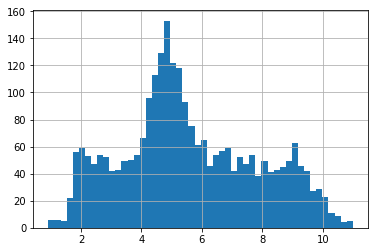

In [65]:
b.mean(1).hist(bins=50);

In [66]:
np.abs(b.median(1)-b.mean(1)).mean()

0.0364857016644724

In [67]:
b.mean(1).mean(),b.median(1).mean()

(5.5739644711471845, 5.570319344038446)

In [68]:
p=b.mean(1).to_frame().reset_index()
p.columns=['seg_id','time_to_failure']
fname =os.path.join(config.INPUT_PATH, "sub", '102', "sub102_{}.csv".format('mean'))
p.to_csv(fname,index=None)

In [69]:
p=b.median(1).to_frame().reset_index()
p.columns=['seg_id','time_to_failure']
fname =os.path.join(config.INPUT_PATH, "sub", '102', "sub102_{}.csv".format('median'))
p.to_csv(fname,index=None)